# HW 2 - Classification, Scoring, and Regularization

Complete the following questions and resubmit this entire notebook to canvas.
- For questions that ask you to derive or find a quantity use a __text cell__ to show your calculations.
 - Use markdown to write math expressions (as was done to create these problems) and make sure to show your work.
 - It doesnt have to be perfect looking but it needs to be readible.
 - You may also submit a legible picture of your derivation
- For questions that ask you compute something or write code use a __code cell__ to write your code.
 - You can create additional code cells as needed.
 - Just make sure your code is commented, the functions are named appropriately, and its easy to see your final answer.

__SUBMISSION__

When you submit you will submit a pdf file __and__ the notebook file. The TA will use the pdf file to grade more quickly. The notebook file is there to confirm your work.

To generate a pdf file
1. Click File
2. Click print
3. Set the destinationas "save as pdf"
4. Hit print

Title the pdf file `LASTNAME-FIRSTNAME-HW2.pdf`
Title your notebook file as `LASTNAME-FIRSTNAME-HW2.ipynb`

Submit both files.

Do not actually print your notebook out (what year is this?)



## Q1 - Classification

In class we used sigmoids and logits to change between probabilities (values on $(0, 1)$) and unbounded values. But this isnt the only option. There are many functions that can map between the two. Another function that does this is

$$g(x) = (\tanh(x) + 1)/2$$

where the hyperbolic tangent function is defined as
$$\tanh(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)}$$

Lets re-implement logistic regression with a hyperbolic tangent non-linearity.


### part 1 - Implement the model

Create a pytorch compatible class called ``LogisticRegressionTanh()`` that is exactly the same as ordinary logistic regression except that the sigmoid is replaced with ``g()``. You may use pytorches built in ``torch.nn.tanh()`` function.

Replace the `pass` statements with your own code

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tqdm.notebook import trange

def g(z):
    return (torch.tanh(z) + 1) / 2

class LogisticRegressionTanh(nn.Module):
    def __init__(self, x, y):
        super(LogisticRegressionTanh, self).__init__()
        self.beta = torch.zeros(x.shape[1]).double().reshape(-1, 1)
        self.beta.requires_grad_()

    def forward(self, x):
        t = x @ self.beta
        p = g(t)
        return p

### part 2 - Comparing with ordinary logistic regression

Using the breast cancer dataset (loaded below)

1. What loss function should we use now that we have a ``tanh()`` nonlinearity instead of a ``sigmoid()`` nonlinearity?

1. Write a gradient descent algorithm to find the optimal parameters of ``LogisticRegressionTanh()`` on the training data using an appropriate loss function

2. Do the same for a standard logistic regression (sigmoid non-linearity) on the training data

3. Compare the __accuracy__, __AUC__, __Brier Score__, and the sensitivity, specificity, and F1 score using a cutoff of $p > 0.5$, of each method on the test data

ANSWER 1. The loss function we can use for tanh() nonlinearity is still BCE loss because the output of g(z) is still between 0 and 1 so binary cross-entropy loss can still measure the distance between the distribution of the predicted probabilities and the actual labels.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

cancer = datasets.load_breast_cancer(as_frame=True)
x, y = cancer.data, cancer.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

x_train = torch.tensor(np.array(x_train))
y_train = torch.tensor(np.array(y_train)).reshape(-1, 1)
x_test = torch.tensor(np.array(x_test))
y_test = torch.tensor(np.array(y_test)).reshape(-1, 1)

In [ ]:
# 2
# BCE Loss function
def bce_loss(model, x, y):
  p = model(x)
  return -torch.mean(y*torch.log(p) + (1-y)*torch.log(1-p))

# ### scale inputs
x_mean = torch.mean(x_train, axis = 0)
x_sd = torch.std(x_train, axis = 0)

x_train = (x_train - x_mean[None,:]) / x_sd[None,:]
x_test = (x_test - x_mean[None,:]) / x_sd[None,:]

# Gradient Descent
lr = LogisticRegressionTanh(x_train, y_train)

loss_trace = np.zeros(10000)

for i in trange(10000):

  # forward pass
  loss = bce_loss(lr, x_train, y_train)
  loss_trace[i] = loss

  # backward pass
  loss.backward()

  # update parameter
  lr.beta.data = lr.beta.data - 1e-3 * lr.beta.grad

  # clear out gradients
  lr.beta.grad.zero_()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
loss_trace

array([0.69314718, 0.68534265, 0.67773297, ..., 0.07710412, 0.07710233,
       0.07710054])

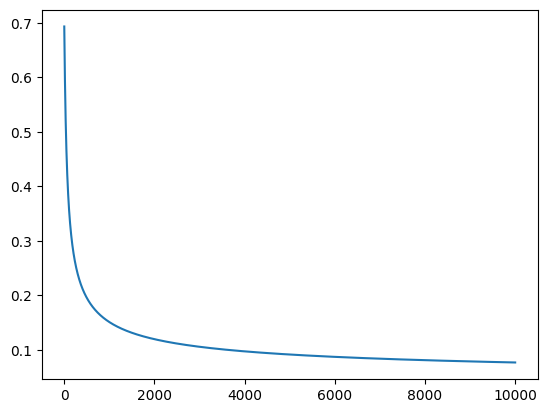

In [ ]:
plt.plot(loss_trace)

In [ ]:
# 3
# Standard Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, x, y):
      super(LogisticRegression, self).__init__()
      self.beta = torch.zeros(x.shape[1]).double().reshape(-1, 1)
      self.beta.requires_grad_()

    def forward(self, x):
      t = x @ self.beta
      p = torch.sigmoid(t)
      return p

lrs = LogisticRegression(x_train, y_train)

loss_trace = np.zeros(10000)

for i in trange(10000):

  # forward pass
  loss = bce_loss(lrs, x_train, y_train)
  loss_trace[i] = loss

  # backward pass
  loss.backward()

  # update parameter
  lrs.beta.data = lrs.beta.data - 1e-2 * lrs.beta.grad

  # clear out gradients
  lrs.beta.grad.zero_()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
loss_trace

array([0.69314718, 0.67382083, 0.65568714, ..., 0.06349426, 0.06349304,
       0.06349181])

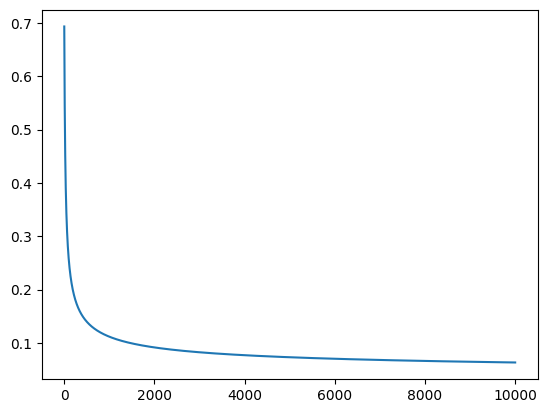

In [ ]:
plt.plot(loss_trace)

In [ ]:
# 4
from sklearn import metrics

# Predictions for LogisticRegressionTanh
y_hat_tanh = (lr(x_test) > 0.5).float()

# Predictions for LogisticRegression
y_hat_sigmoid = (lrs(x_test) > 0.5).float()

In [ ]:
tn_tanh, fp_tanh, fn_tanh, tp_tanh = metrics.confusion_matrix(y_test, y_hat_tanh).ravel()

# Accuracy
acc_tanh = (tp_tanh + tn_tanh) / (tp_tanh + fp_tanh + fn_tanh + tn_tanh)

# Sensitivity and Specificity
sensitivity_tanh = tp_tanh / (tp_tanh + fn_tanh)
specificity_tanh = tn_tanh / (tn_tanh + fp_tanh)

# F1 Score
f1_tanh = (2 * tp_tanh) / (2 * tp_tanh + fp_tanh + fn_tanh)

# Brier Score
probs_tanh = lr(x_test).detach().numpy()
brier_score_tanh = np.mean((probs_tanh - y_test.numpy())**2)

# AUC
auc_tanh = metrics.roc_auc_score(y_test, lr(x_test).detach())

# Printing
print(f"LogisticRegressionTanh Metrics:\nAccuracy: {acc_tanh}\nSensitivity: {sensitivity_tanh}\nSpecificity: {specificity_tanh}\nF1 Score: {f1_tanh}\nBrier Score: {brier_score_tanh}\nAUC: {auc_tanh}")

LogisticRegressionTanh Metrics:
Accuracy: 0.9787234042553191
Sensitivity: 0.9752066115702479
Specificity: 0.9850746268656716
F1 Score: 0.9833333333333333
Brier Score: 0.018065283367208418
AUC: 0.9985197977056864


In [ ]:
tn_sigmoid, fp_sigmoid, fn_sigmoid, tp_sigmoid = metrics.confusion_matrix(y_test.numpy(), y_hat_sigmoid.detach().numpy()).ravel()

# Accuracy
acc_sigmoid = (tp_sigmoid + tn_sigmoid) / (tp_sigmoid + fp_sigmoid + fn_sigmoid + tn_sigmoid)

# Sensitivity and Specificity
sensitivity_sigmoid = tp_sigmoid / (tp_sigmoid + fn_sigmoid)
specificity_sigmoid = tn_sigmoid / (tn_sigmoid + fp_sigmoid)

# F1 Score
f1_sigmoid = (2 * tp_sigmoid) / (2 * tp_sigmoid + fp_sigmoid + fn_sigmoid)

# Brier Score
probs_sigmoid = lrs(x_test).detach().numpy()
brier_score_sigmoid = np.mean((probs_sigmoid - y_test.numpy())**2)

# AUC
auc_sigmoid = metrics.roc_auc_score(y_test.numpy(), lrs(x_test).detach().numpy())

# Printing
print(f"LogisticRegression Sigmoid Metrics:\nAccuracy: {acc_sigmoid}\nSensitivity: {sensitivity_sigmoid}\nSpecificity: {specificity_sigmoid}\nF1 Score: {f1_sigmoid}\nBrier Score: {brier_score_sigmoid}\nAUC: {auc_sigmoid}")

LogisticRegression Sigmoid Metrics:
Accuracy: 0.9840425531914894
Sensitivity: 0.9834710743801653
Specificity: 0.9850746268656716
F1 Score: 0.9875518672199171
Brier Score: 0.01525653172580073
AUC: 0.9983964475144936


PART 4 NOTES: When Comparing various scores I found that the standard logistic regression miodel performed better in that it had slightly higher scores for Accuracy, Sensitivity, F1, and AUC and it had a lower Brier Score. I thought it was interesting to see the Specificity score come out as the same for both the sigmoid and the tanh so both models have the same ability to successfully classify 0's as 0's in the logistic regression.

## Q2 - Class imbalance

Download the climate simulation crash dataset from the following link
- https://archive.ics.uci.edu/ml/datasets/Climate+Model+Simulation+Crashes

Linux, OSX, and collab users can use the following shell command to autodownload it.



In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat

--2024-02-26 03:58:37--  https://archive.ics.uci.edu/ml/machine-learning-databases/00252/pop_failures.dat
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘pop_failures.dat.1’

pop_failures.dat.1      [ <=>                ] 244.26K  --.-KB/s    in 0.04s   

2024-02-26 03:58:37 (6.12 MB/s) - ‘pop_failures.dat.1’ saved [250119]



In [ ]:
import pandas as pd
climate = pd.read_csv('pop_failures.dat', sep="\s+")
print(climate.columns)

Index(['Study', 'Run', 'vconst_corr', 'vconst_2', 'vconst_3', 'vconst_4',
       'vconst_5', 'vconst_7', 'ah_corr', 'ah_bolus', 'slm_corr',
       'efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale',
       'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq',
       'bckgrnd_vdc_psim', 'Prandtl', 'outcome'],
      dtype='object')


### part 1 - Training

Your task is to predict the last column `'outcome'` using the other columns except `'Study'` and `'Run'`. As always we will evaluate everything on test.
 - note: `'outcome'` records __failures as 0__. You need to swap the 0s to 1s and the 1s to 0s before proceeding because we want to predict failure.

1. Split the data into train/validation/test. You may use functions from sklearn. Hint: Split into train/test then further split train into train/val.

2. Write your own logistic regression model and fit it with your gradient descent loop on the climate dataset.

3. Keep track of your loss on train __and__ your loss on the validation set and plot each loss trace. Compare the two loss traces and state whether there is any evidence of overfitting or not. (Do not call backward on your validation loss)

In [ ]:
from sklearn.model_selection import train_test_split

# Swap the outcome values
climate['outcome'] = climate['outcome'].apply(lambda x: 0 if x == 1 else 1)

# Drop Study and Run columns
X = climate.drop(columns=['Study', 'Run', 'outcome'])
y = climate['outcome']

# Split the data into train test then train val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)


class LogisticRegression(nn.Module):
    def __init__(self, dim):
      super(LogisticRegression, self).__init__()
      self.beta = torch.zeros(dim, 1, dtype=torch.double)
      self.beta.requires_grad_()

    def forward(self, x):
      t = x @ self.beta
      p = torch.sigmoid(t)
      return p
dim = X_train.shape[1]
lrs = LogisticRegression(dim)

# Convert data to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.double)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.double)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.double)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.double).reshape(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.double).reshape(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.double).reshape(-1, 1)

# Loss function and gradient descent loop
def bce_loss(model, x, y):
  p = model(x)
  return -torch.mean(y*torch.log(p) + (1-y)*torch.log(1-p))

loss_trace_train = np.zeros(10000)
loss_trace_val = np.zeros(10000)

for i in trange(10000):

  loss_train = bce_loss(lrs, X_train_tensor, y_train_tensor)
  loss_trace_train[i] = loss_train
  # Backward pass
  loss_train.backward()
  # Update parameters
  lrs.beta.data -= 1e-1 * lrs.beta.grad.data
  # Clear out gradients
  lrs.beta.grad.zero_()

  loss_val = bce_loss(lrs, X_val_tensor, y_val_tensor)
    # Store validation loss
  loss_trace_val[i] = loss_val

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
loss_trace_val

array([0.62325543, 0.56852092, 0.52548487, ..., 0.16703237, 0.1670318 ,
       0.16703122])

In [ ]:
loss_trace_train

array([0.69314718, 0.62131704, 0.56449748, ..., 0.1527703 , 0.15276966,
       0.15276902])

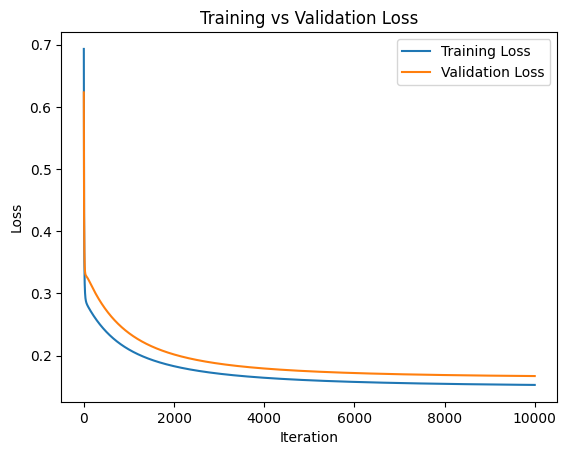

In [ ]:
plt.plot(loss_trace_train, label='Training Loss')
plt.plot(loss_trace_val, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

I don't see any signs of overfitting since both the train and validation loss converge to similar values with train loss slightly lower. Since both loss follow the same trend without significant divergence, I think the model is generalizing well to the unseen data in the validation set.

### part 2 - Evaluate

1. Compute the accuracy of your model on the test set. Would you consider this model accurate (over 90%?)

2. State precisely what sensitivity and specificy mean then compute the sensitivity and specificty of this model.

3. Suppose its very important that we can predict if the climate simulation will crash when its actually going to crash.  Does our model do a good job of this (over 90%?) Use sensitivity or specificity to inform your answer.


In [ ]:
y_hat_test = (lrs(X_test_tensor) > 0.5).float()

# Calculate the confusion matrix elements
tn_test, fp_test, fn_test, tp_test = metrics.confusion_matrix(y_test_tensor.numpy(), y_hat_test.detach().numpy()).ravel()

# Accuracy
acc_test = (tp_test + tn_test) / (tp_test + fp_test + fn_test + tn_test)

# Sensitivity and Specificity
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

print(f"Model Test Metrics:\nAccuracy: {acc_test}\nSensitivity: {sensitivity_test}\nSpecificity: {specificity_test}")

Model Test Metrics:
Accuracy: 0.9555555555555556
Sensitivity: 0.6363636363636364
Specificity: 0.9838709677419355


ANSWERS

1. Yes I would consider this model accurate if we were basing this solely from the accuracy output of 95.5%, however this accuracy score can sometimes be misleading if the model is much better at predicting 1's than 0's or vice versa.

2. Sensitivity means the true positive rate and is the models ability to successfully classify 1s as 1s. It is the proportion of observations that do have the condition that are classified as having the condition, calculated as true positives / (true positives + false negatives). Specificity is the true negative rate and is the models ability to successfully classify 0s as 0s.It is the proportion of observations that do not have the condition that are classified as not having the condition, calculated as true negatives / (true negatives + false positives).

3. To check the accuracy of predicting if the climate simulation will crash when its actually going to crash we look at sensitivity because we have failures as 1s in our model so we want to see the rate that the model is classifying a 1 when it is a 1. Our model does NOT do a good job of this with a sensitivity of only about .63.

### part 3 - Reweight and retrain

1. Plot the confusion matrix to see if you can diagnose the issue. You may use sklearn's confusion matrix function or you can do it. Describe what the problem likely is.

2. How should we weight the loss function to account for this? and why might that help? Then modify the loss function to use inverse weight scheme described in class. Refit your model and report the test sensitivity and specificity.

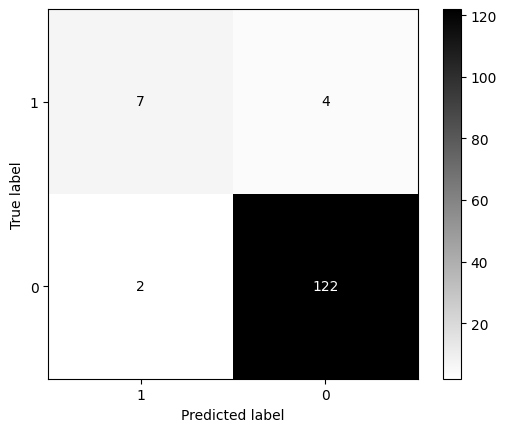

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

X_test_tensor = torch.tensor(X_test.values, dtype=torch.double)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.double).reshape(-1, 1)
yhat_test = (lrs(X_test_tensor) > 0.5).float()

conf_matrix = metrics.confusion_matrix(y_test_tensor, yhat_test)

# Plot the confusion matrix
conf_matrix_display = ConfusionMatrixDisplay(np.rot90(np.rot90(conf_matrix)), display_labels = [1, 0])
conf_matrix_display.plot(cmap = 'binary')
plt.show()

ANSWER

1. From the confusion matrix I see that the problem is likely that there is only 11 observations in the dataset with a true label of 1 while there is 124 with a true label of 0. This is giving the model a bias to the majority classification of 0's.

2. To fix the class bias from a lack of observations we should weight the loss function so that errors in the class representing failures (the 1's) are considered more significant than errors in the majority class (the 0's). This is perfect for our scenario because the cost of a false negative (A 1 that is classified as a 0) is higher than the cost of a false positive. We should assign weights inversely proportional to the class frequencies. By reweighting the loss function, we tell the model that making an incorrect classification on the minority class is more costly. This change to the loss function allows the model to improve its performance on predicting the failure class that has just 11 observations making have a higher sensitivity which is what we want.

In [ ]:
# Calculate the class proportions
total_count = len(y_train)
class_1_weight = total_count / (y_train == 1).sum()
class_0_weight = total_count / (y_train == 0).sum()

# Normalize weights to sum to 1
weight1 = class_1_weight / (class_1_weight + class_0_weight)
weight0 = class_0_weight / (class_1_weight + class_0_weight)

# Print the weights
print(f"Weight for class 1: {weight1}")
print(f"Weight for class 0: {weight0}")

Weight for class 1: 0.922509225092251
Weight for class 0: 0.07749077490774908


In [ ]:
# Wieghted bce
def weighted_bce_loss(model, x, y, w1, w0):
    p = model(x)
    return -torch.mean(w1 * y * torch.log(p) + w0 * (1 - y) * torch.log(1 - p))

loss_trace_train = np.zeros(10000)


# Retrain the model
for i in trange(10000):
    loss = weighted_bce_loss(lrs, X_train_tensor, y_train_tensor, weight1, weight0)
    loss_trace_train[i] = loss
    # Backward pass
    loss.backward()

    # Update parameters
    lrs.beta.data -= 1e-2 * lrs.beta.grad.data

    # Clear out gradients
    lrs.beta.grad.zero_()


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
loss_trace_train

array([0.08906972, 0.08899695, 0.0889243 , ..., 0.04265724, 0.04265719,
       0.04265715])

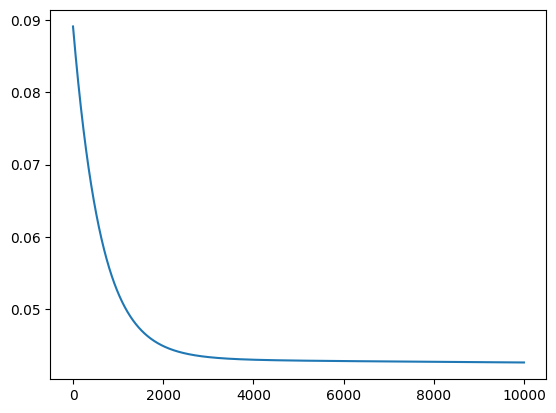

In [ ]:
plt.plot(loss_trace_train)

In [ ]:
yhat_test = (lrs(X_test_tensor) > 0.5).float()

conf_matrix = metrics.confusion_matrix(y_test_tensor, yhat_test)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Weighted Sensitivity: {sensitivity}")
print(f"Weighted Specificity: {specificity}")

Sensitivity: 1.0
Specificity: 0.8064516129032258


NOTE:This model is much better because of how important it is to us in this scenario to properly classify a crash failure as a crash failure so I am willing to sacrifice some specificity for a much better sensitivity.

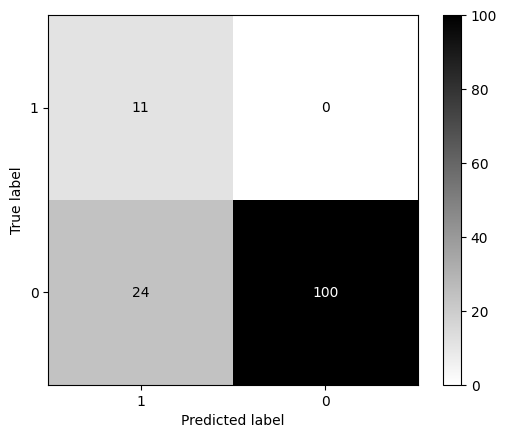

              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89       124
         1.0       0.31      1.00      0.48        11

    accuracy                           0.82       135
   macro avg       0.66      0.90      0.69       135
weighted avg       0.94      0.82      0.86       135



In [ ]:
conf_matrix_display = ConfusionMatrixDisplay(np.rot90(np.rot90(conf_matrix)), display_labels = [1, 0])
conf_matrix_display.plot(cmap = 'binary')
plt.show()

## Q3 - Multi-target Classification

Here we will implement mutli-target logistic regression, so that we can perform classification with more than two labels.

We will use a "rectangles" dataset to test out our method. Your task is simple. Given an image classify whether it contains a blue rectangle, a red rectangle, a green rectangle, or no rectangle. We will generate this dataset below so please do not change the seeds.


### Recall: multi-target logistic regression

A multi-target logistic regression when we have $k$ categories is defined as
\begin{align}
y_i &\sim Categorical((p_1,...,p_k)_i) \\
(p_1,...,p_k)_i &= \sigma(x_i\beta + \alpha)
\end{align}

How to read this:
1. Take a $p$ dimensional input vector $x_i$ and multiple it by the __matrix__ $\beta_{p \times k}$ then add the vector $\alpha_{1\times k}$ to get a $k$ dimensional vector of log probabilties

2. Squash the log probabilities $z_i = x_i\beta + \alpha$ to all be between 0 and 1, and sum to 1, by applying the __softmax function__ $\sigma(\cdot)$. The $j$'th entry $(j = 1,...,k)$ of $\sigma(z_i)$ is equal to
$$
\sigma(z_i)_j = \frac{\exp((z_i)_j)}{\sum_{j = 1}^k\exp((z_i )_j)}
$$
where $((z_i)_j)$ means the  $j$'th entry of $z_i$.

3. We say $y_i$ belongs to class $j$ with probability $\sigma(z_i)_j$

Also recall:
We represent $Y_{n\times1}$ as a $Y_{n\times k}$ one-hot encoded matrix so that we can derive the __multi-target BCE loss__ function from the categorical distribution as

\begin{align}
\mathcal{L}(\beta) &= -\frac{1}{nk}\sum_{i=1}^n \sum_{j=1}^k y_{i,j} \log(\sigma(x_i \beta))_j \\
\end{align}

In [ ]:
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from skimage.draw import random_shapes
from skimage.util import random_noise

Generate the rectangle data below

In [ ]:
m1, m2, m3, m4 = 200, 200, 200, 200
n = m1 + m2 + m3 + m4

rng = 0

## generate blues
blue_imgs = []
for _ in trange(m1):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((20, 20),(20,20),(255,255)),
                         random_seed = rng)

  img = random_noise(img, mode='speckle', var = 0.03, seed = rng)
  blue_imgs.append(img)
  rng += 1

blue_imgs = np.array(blue_imgs)
blue_labs = 0*np.ones(m1)

## generate reds
red_imgs = []
for _ in trange(m2):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((255,255),(20, 20),(20,20)),
                         random_seed = rng)

  img = random_noise(img, mode='speckle', var = 0.03, seed = rng)
  red_imgs.append(img)
  rng += 1

red_imgs = np.array(red_imgs)
red_labs = 1*np.ones(m2)

## generate greens
green_imgs = []
for _ in trange(m3):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((20, 20),(255,255),(20,20)),
                         random_seed = rng)

  img = random_noise(img, mode='speckle', var = 0.03, seed = rng)
  green_imgs.append(img)
  rng += 1

green_imgs = np.array(green_imgs)
green_labs = 2*np.ones(m3)

## generate blanks
none_imgs = []
for _ in trange(m4):
  img, _ = random_shapes(image_shape = (32, 32),
                         min_size = 10,
                         max_size = 20,
                         max_shapes = 1,
                         shape = 'rectangle',
                         intensity_range=((255, 255),(255,255),(255,255)),
                         random_seed = rng)

  img = random_noise(img, mode='speckle', var = 0.03, seed = rng)
  none_imgs.append(img)
  rng += 1

none_imgs = np.array(none_imgs)
none_labs = 3*np.ones(m4)

imgs = np.vstack([blue_imgs, red_imgs, green_imgs, none_imgs])
labs = np.concatenate([blue_labs, red_labs, green_labs, none_labs]).astype(np.int64)
np.random.seed(0)
idx = np.random.permutation(np.arange(n))
imgs = imgs[idx]
labs = labs[idx]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

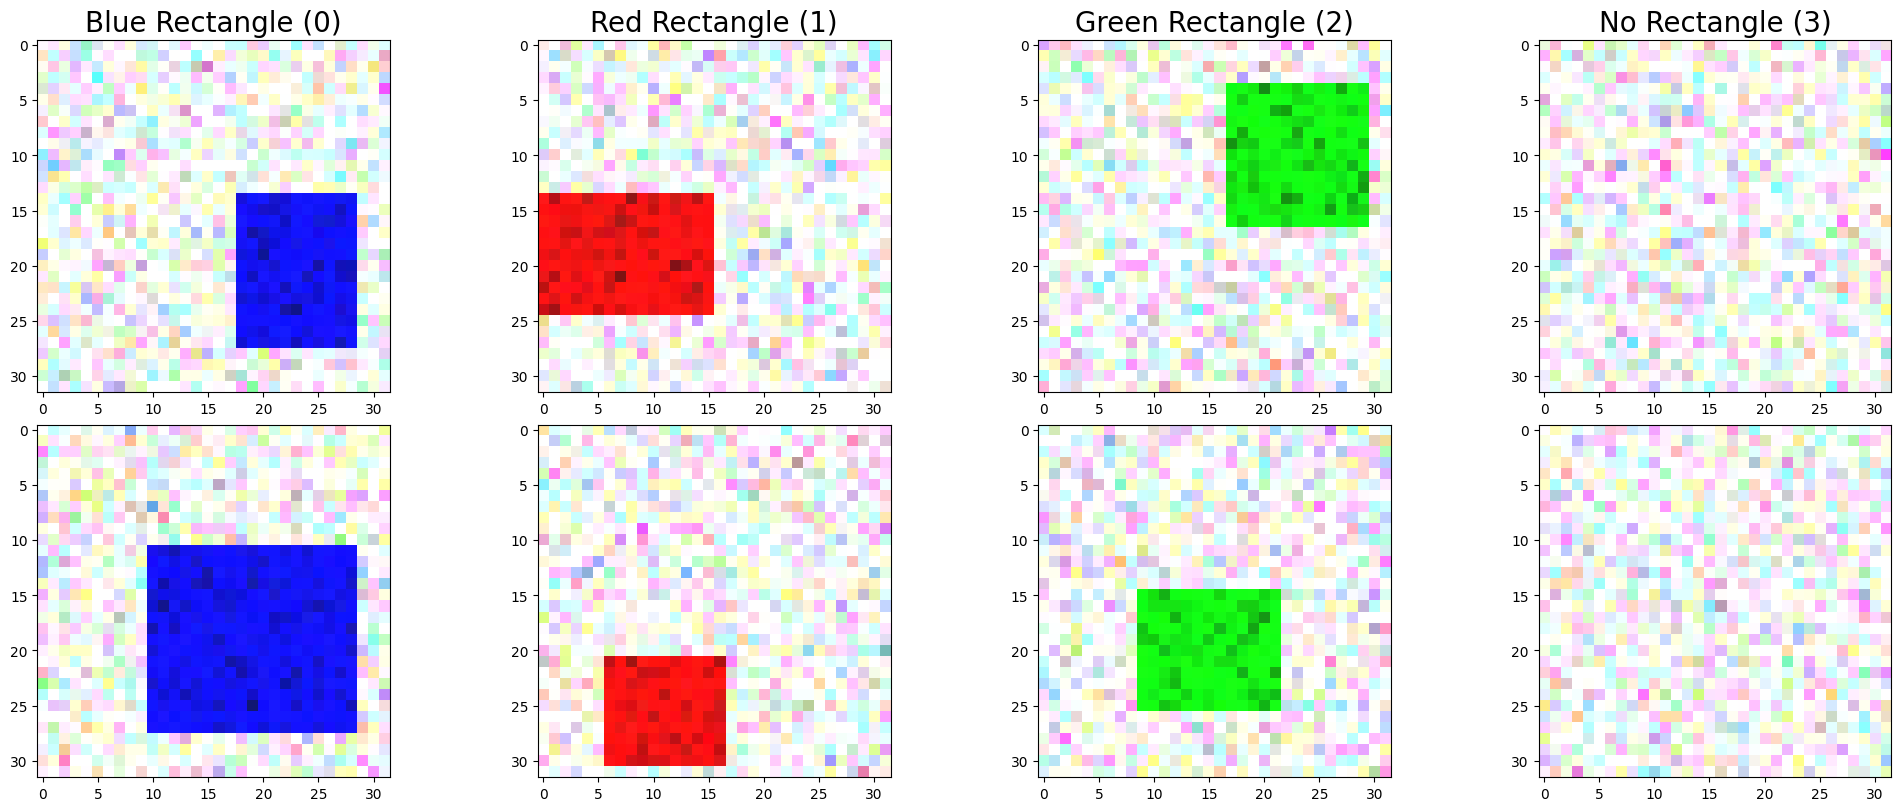

In [ ]:
fig, ax = plt.subplots(2, 4, constrained_layout = True, figsize = (20, 8))
ax[0,0].imshow(blue_imgs[0])
ax[0,1].imshow(red_imgs[0])
ax[0,2].imshow(green_imgs[0])
ax[0,3].imshow(none_imgs[0])

ax[1,0].imshow(blue_imgs[1])
ax[1,1].imshow(red_imgs[1])
ax[1,2].imshow(green_imgs[1])
ax[1,3].imshow(none_imgs[1])

ax[0,0].set_title('Blue Rectangle (0)', fontsize = 20)
ax[0,1].set_title('Red Rectangle (1)', fontsize = 20)
ax[0,2].set_title('Green Rectangle (2)', fontsize = 20)
ax[0,3].set_title('No Rectangle (3)', fontsize = 20)
plt.show()

The above plots show an example of each class. We code blue as 0, red as 1, green as 2, and none as 3. Each image contains a fair amount of degredation and rectangles are randomly generated somewhere in the image with a random size.

In [ ]:
from torch.nn.functional import one_hot
from sklearn.model_selection import train_test_split

x = torch.tensor(imgs).reshape(n, -1)
y = one_hot(torch.tensor(labs))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

### part 1 - Implement the model

Lets create a class called `MultiLogisticRegression`. This class should do the following

1. Automatically determine the shapes of $\beta$ and $\alpha$ from the data `x` and `y`
2. Initialize $\alpha$ and $\beta$ at 0 and enable gradient tracking
3. Include a `forward()` function that computes class probabilities given input `x`
4. Include a `classify()` function that classifies inputs `x`, i.e. return the class with the highest probability.


To make sure its working. Instantiate your class and call the forward function on `x_train`. Print the output (it should be a tensor of all $0.25$)

_hint 1: Do not forget alpha! Also make sure alpha is 4 dim since you want an intercept (bias) for each target class_

_hint 2: Try 1000-3000 training iterations with a learning rate between 1e-2 and 1e-3_

_hint 3: Consider using a mean rather than a sum in your ridge/lasso penalties to automatically scale the penalty by the sample size_


In [ ]:
class MultiLogisticRegression(nn.Module):
    def __init__(self, dim, num_classes):
        super(MultiLogisticRegression, self).__init__()
        self.beta = torch.zeros(dim, num_classes, dtype=torch.double)
        self.alpha = torch.zeros(1, num_classes, dtype=torch.double)
        self.beta.requires_grad_()
        self.alpha.requires_grad_()

# Compute the log probabilities and apply softmax
    def forward(self, x):
        t = x @ self.beta + self.alpha
        p = torch.exp(t) / torch.exp(t).sum(dim=1, keepdim=True)
        return p

# Get the class with the highest probability
    def classify(self, x):
        probabilities = self.forward(x)
        return probabilities.argmax(dim=1)


In [ ]:
# Check to make sure its working
# Number of features and number of classes
num_features = x_train.shape[1]
num_classes = y_train.shape[1]

# Instantiate the model
model = MultiLogisticRegression(num_features, num_classes)

x_train = x_train.double()
y_train = y_train.double()
x_test = x_test.double()
y_test = y_test.double()

# Perform a forward pass and print the output
output = model(x_train)
print(output)

tensor([[0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        ...,
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500],
        [0.2500, 0.2500, 0.2500, 0.2500]], dtype=torch.float64,
       grad_fn=<DivBackward0>)


In [ ]:
# Loss function for multi-class classification
def ce_loss(model, x, y):
    p = model(x)
    return -torch.mean(torch.sum(y * torch.log(p), axis=1))

# Training loop
learning_rate = 1e-3
n_iter = 1000

loss_trace = np.zeros(n_iter)

for i in trange(n_iter):
# Forward pass to get the probabilities
    y_pred = model(x_train)

# Compute loss
    loss = ce_loss(model, x_train, y_train)
    loss_trace[i] = loss
# Backward pass
    loss.backward()

# Update
    model.beta.data -= learning_rate * model.beta.grad.data
    model.alpha.data -= learning_rate * model.alpha.grad.data

# Zero gradients
    model.zero_grad()


  0%|          | 0/1000 [00:00<?, ?it/s]

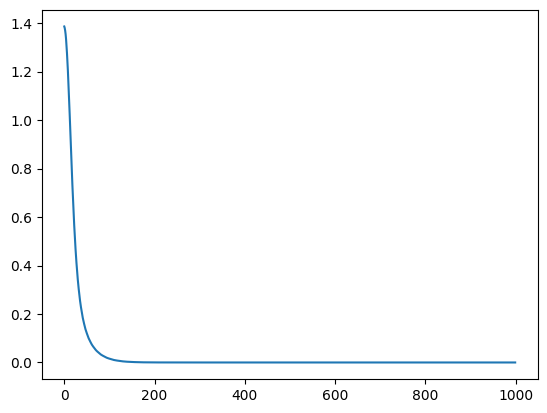

In [ ]:
plt.plot(loss_trace)

### Part 2 - Training

1. Train three multi-target logisitic regression models on the rectangles dataset to classify images of rectangles. Use the model you just constructed and write your own loss functions. Write your own gradient descent loop. Fit the three models by training with
  1. cross entropy
  2. cross entropy with a ridge penalty
  3. cross entropy with a LASSO penalty

2. Plot the loss trace (did it converge?) for each model and print the test __accuracy__ and __cross entropy__ for each model. The test accuracy needs to be above $0.97$ or the test cross entropy needs to be below $0.1$ for at least one of these models. State which model performed the best on test in terms of cross entropy or accuracy.

3. 5% bonus points if you achieve a test accuracy over $0.994$ (its possible)

In [ ]:
# Regular BCE Loss
def ce_loss(model, x, y):
    p = model(x)
    return -torch.mean(torch.sum(y * torch.log(p), axis=1))

# Ridge Loss
def ridge_loss(model, x, y, lam):
    ce = ce_loss(model, x, y)
    ridge_penalty = lam * torch.mean(model.beta ** 2)
    return ce + ridge_penalty

# Lasso Loss
def lasso_loss(model, x, y, lam):
    ce = ce_loss(model, x, y)
    lasso_penalty = lam * torch.mean(torch.abs(model.beta))
    return ce + lasso_penalty

In [ ]:
learning_rate = 1e-3
n_iter = 1000

# Instantiate
model_ce = MultiLogisticRegression(num_features, num_classes)

# Loss Traces
loss_trace_ce = np.zeros(n_iter)

# Train with regular cross entropy
for i in trange(n_iter):
    loss = ce_loss(model_ce, x_train, y_train)
    loss_trace_ce[i] = loss

    loss.backward()

    # Update parameters
    model_ce.beta.data -= learning_rate * model_ce.beta.grad.data
    model_ce.alpha.data -= learning_rate * model_ce.alpha.grad.data

    # Zero gradients
    model_ce.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

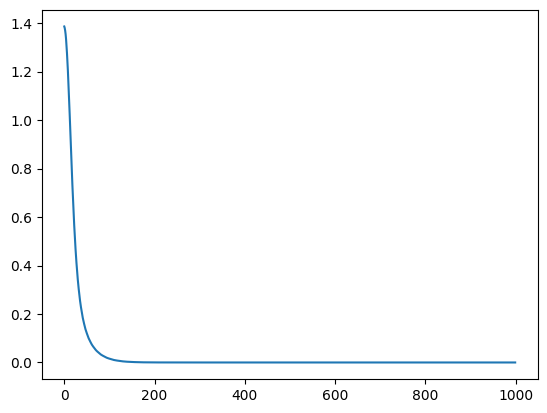

In [ ]:
plt.plot(loss_trace_ce)

In [ ]:
# Predict the classes for the test set
y_pred_classes = model.classify(x_test)

# Convert one-hot encoded test labels to class labels
y_true_classes = y_test.argmax(dim=1)

# Calculate the accuracy
accuracy = (y_pred_classes == y_true_classes).double().mean().item()

print(f'CE Accuracy: {accuracy:.4f}')

CE Accuracy: 0.9924


In [ ]:
# Printing the Test Cross Enthropy For Basic CE
ce_loss(model_ce, x_test, y_test)

tensor(0.2966, dtype=torch.float64, grad_fn=<NegBackward0>)

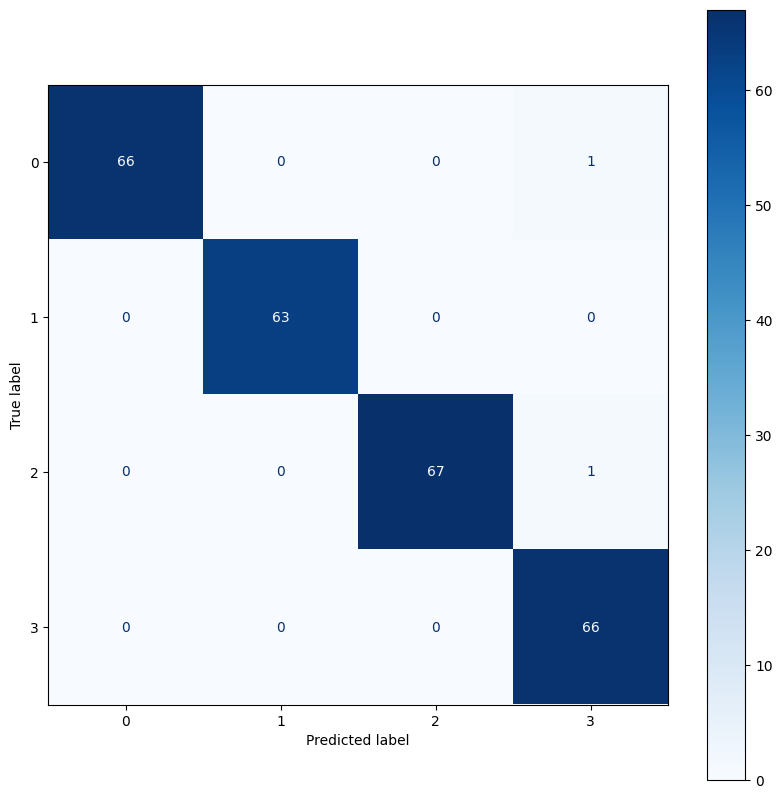

In [ ]:
# Confusion Matrix For the Cross Enthropy Model to Confirm Accuracu
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_classes = model.classify(x_test)

y_true_classes = y_test.argmax(dim=1)

y_pred_classes_np = y_pred_classes.numpy()
y_true_classes_np = y_true_classes.numpy()

conf_matrix = metrics.confusion_matrix(y_true_classes_np, y_pred_classes_np)

conf_matrix_display = ConfusionMatrixDisplay(conf_matrix)
fig, ax = plt.subplots(figsize=(10, 10))
conf_matrix_display.plot(ax=ax, cmap='Blues')
plt.show()

In [ ]:
# Train with Ridge penalty
model_ridge = MultiLogisticRegression(num_features, num_classes)
loss_trace_ridge = np.zeros(n_iter)

lam_ridge = 0.1
for i in trange(n_iter):
    loss = ridge_loss(model_ridge, x_train, y_train, lam_ridge)
    loss_trace_ridge[i] = loss

    loss.backward()

    # Update parameters
    model_ridge.beta.data -= learning_rate * model_ridge.beta.grad.data
    model_ridge.alpha.data -= learning_rate * model_ridge.alpha.grad.data

    # Zero gradients
    model_ridge.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

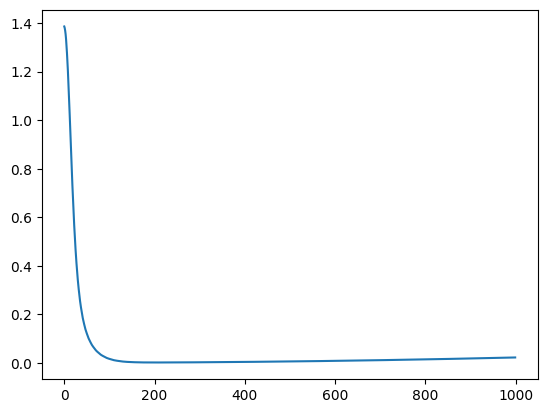

In [ ]:
plt.plot(loss_trace_ridge)

In [ ]:
y_pred_classes_ridge = model_ridge.classify(x_test)

y_true_classes = y_test.argmax(dim=1)

accuracy_ridge = (y_pred_classes_ridge == y_true_classes).float().mean().item()

print(f'Accuracy with Ridge penalty: {accuracy_ridge:.4f}')

Accuracy with Ridge penalty: 0.9924


In [ ]:
# Printing the Test Cross Enthropy For Ridge
ce_loss(model_ridge, x_test, y_test)

tensor(0.2957, dtype=torch.float64, grad_fn=<NegBackward0>)

In [ ]:
# Train with lasso penalty
model_lasso = MultiLogisticRegression(num_features, num_classes)

loss_trace_lasso = np.zeros(n_iter)

lam_lasso = 0.1
for i in trange(n_iter):
    loss = lasso_loss(model_lasso, x_train, y_train, lam_lasso)
    loss_trace_lasso[i] = loss

    loss.backward()

    # Update parameters
    model_lasso.beta.data -= learning_rate * model_lasso.beta.grad.data
    model_lasso.alpha.data -= learning_rate * model_lasso.alpha.grad.data

    # Zero gradients
    model_lasso.zero_grad()

  0%|          | 0/1000 [00:00<?, ?it/s]

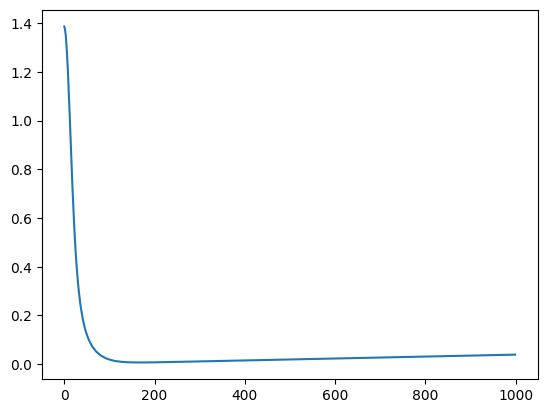

In [ ]:
plt.plot(loss_trace_lasso)

In [ ]:
# Lasso Accuracy
y_pred_classes_lasso = model_lasso.classify(x_test)

y_true_classes = y_test.argmax(dim=1)

accuracy_lasso = (y_pred_classes_lasso == y_true_classes).float().mean().item()

print(f'Accuracy with Lasso penalty: {accuracy_lasso:.4f}')

Accuracy with Lasso penalty: 0.9924


In [ ]:
# Printing the Test Cross Enthropy For Ridge
ce_loss(model_lasso, x_test, y_test)

tensor(0.2816, dtype=torch.float64, grad_fn=<NegBackward0>)

ANSWER TO QUESTIONS:

2. Plot the loss trace (did it converge?) for each model and print the test accuracy and cross entropy for each model. The test accuracy needs to be above  0.97  or the test cross entropy needs to be below  0.1  for at least one of these models. State which model performed the best on test in terms of cross entropy or accuracy.

The loss converged for the Corss enthropy model, but for both the ridge and lasso model where I used a lamda value of .1, it appeared to converge and then the loss started increasing again. The test accuracy was .9924 for all models which tells me that the lamba values I am using are not impacting the model weights and it's accuracy super significantly and the model doesn't necessarily need the added regularization if we want simplicity. However, the model with the lowest Cross Enthropy was the Lasso model with .2816 and the highest Cross Enthropy was the original cross enthropy model with .2966. Even though it is a small difference it the lower cross enthropy for the lasso model indicates that the probabilities assigned to the correct classes are higher. A .2816 cross enthropy isn't necessarily great though as below .1 is ideal.


### Part 3 - Evaluate

1. Check the classification report for whichever model performed the best. Are there any colors (classes) that your model performed particularly poorly on? How might you improve your model on specific classes?

The Lasso Model performed the best with the lowest Cross enthropy but I decided to check the classification report for all 3 models below. For the No Rectangle class (class 3) we have slightly poorer precision meaning that there is some observations that we classified in class 3 that is not in class 3. Overall the model is very good when it comes to accuracy, precision, recall, and F1 score, but one way to improve the model for specified classes would be to add wieghts in the loss function for observations in that class so that the model sees more importance in that class. We do not really need this for our current model, but it is a general option for multi-logistic regression.

In [ ]:
# Getting the Test Accuracy
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report

# True labels
y_true_classes = y_test.argmax(dim=1).numpy()

# Predicted labels for each model
y_pred_classes_ce = model_ce.classify(x_test).numpy()
y_pred_classes_ridge = model_ridge.classify(x_test).numpy()
y_pred_classes_lasso = model_lasso.classify(x_test).numpy()

# Generate and print the classification report for each model
print("Cross Entropy Model Classification Report:")
print(classification_report(y_true_classes, y_pred_classes_ce))

print("Ridge Model Classification Report:")
print(classification_report(y_true_classes, y_pred_classes_ridge))

print("Lasso Model Classification Report:")
print(classification_report(y_true_classes, y_pred_classes_lasso))


Cross Entropy Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        67
           1       1.00      1.00      1.00        63
           2       1.00      0.99      0.99        68
           3       0.97      1.00      0.99        66

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264

Ridge Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        67
           1       1.00      1.00      1.00        63
           2       1.00      0.99      0.99        68
           3       0.97      1.00      0.99        66

    accuracy                           0.99       264
   macro avg       0.99      0.99      0.99       264
weighted avg       0.99      0.99      0.99       264

Lasso Model Classification Report:
              pre